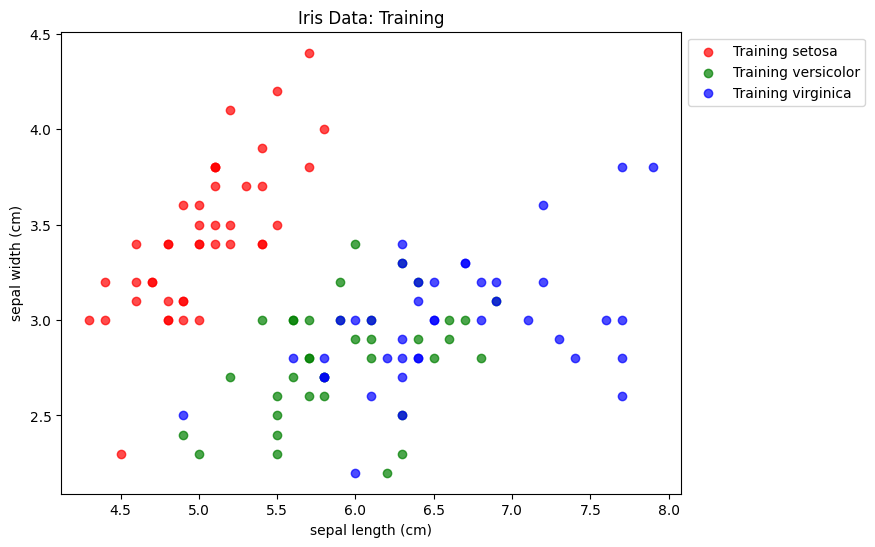

'# Print the shapes of the datasets\nprint("TRAIN_DATA shape:", TRAIN_DATA.shape)\nprint("TRAIN_LABELS shape:", TRAIN_LABELS.shape)\nprint("TEST_DATA shape:", TEST_DATA.shape)\nprint("TEST_LABELS shape:", TEST_LABELS.shape)\n\nprint(TRAIN_DATA)\nprint(TRAIN_LABELS)'

In [273]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# Load the Iris dataset
iris = load_iris()
# Select sepal length (index 0) and sepal width (index 1)
data = iris.data[:, :2]
labels = iris.target
# Split the dataset into training and test sets
TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = train_test_split(
    data, labels, train_size=130, test_size=20, random_state=None, stratify=labels
)
# Add a gap of 0.3 to the data
TRAIN_DATA += 0.3
TEST_DATA += 0.3
# Select sepal length and sepal width for visualization
data_train = x_train[:, :2]
data_test = x_test[:, :2]

# Create the plot
plt.figure(figsize=(8, 6))

# Define the color map and flower names
colors = ['red', 'green', 'blue']
flower_names = iris.target_names

# Plot training data
for i, color in enumerate(colors):
    plt.scatter(data_train[y_train == i, 0], data_train[y_train == i, 1], 
                color=color, marker='o', label=f'Training {flower_names[i]}', alpha=0.7)


# Set labels and title
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Iris Data: Training")

# Add a legend
plt.legend(bbox_to_anchor=(1, 1),
           loc='upper left')

# Show the plot
plt.show()
'''# Print the shapes of the datasets
print("TRAIN_DATA shape:", TRAIN_DATA.shape)
print("TRAIN_LABELS shape:", TRAIN_LABELS.shape)
print("TEST_DATA shape:", TEST_DATA.shape)
print("TEST_LABELS shape:", TEST_LABELS.shape)

print(TRAIN_DATA)
print(TRAIN_LABELS)'''

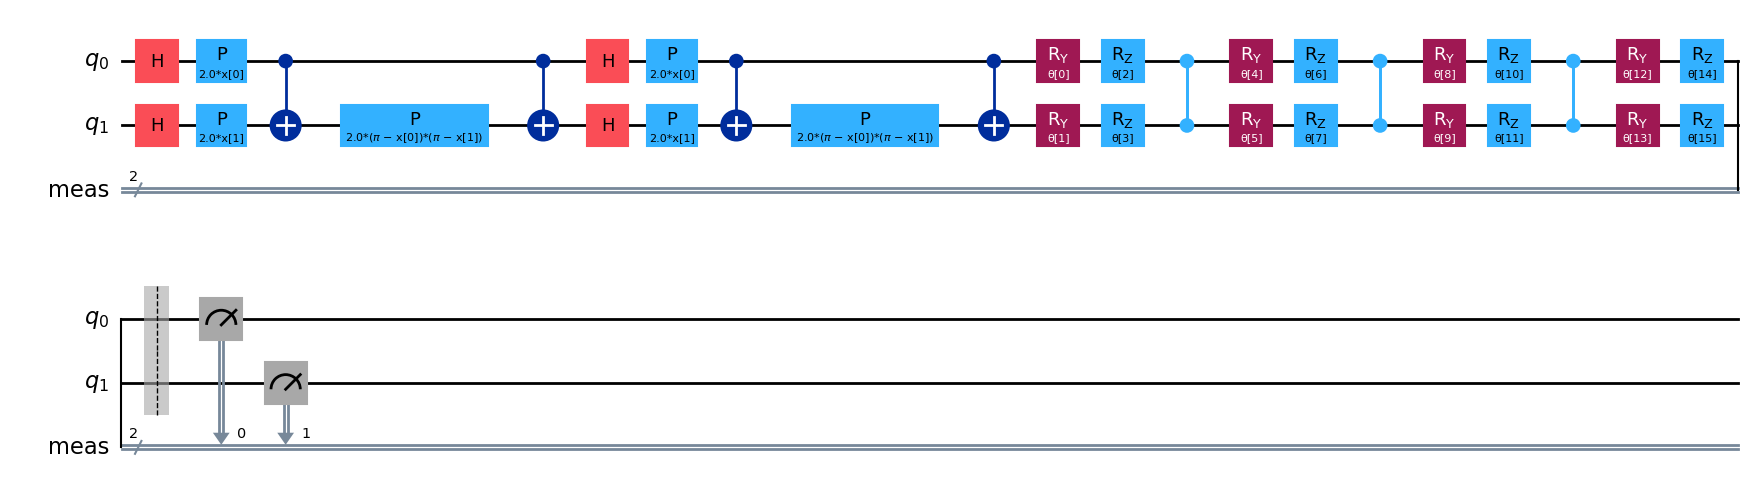

In [274]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=3)

iris_circuit = FEATURE_MAP.compose(VAR_FORM)
iris_circuit.measure_all()
iris_circuit.decompose().draw('mpl')

In [275]:
def circuit_data(data,vars):
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = vars[i]
    return iris_circuit.assign_parameters(parameters)

In [276]:
from qiskit_aer import Aer
from qiskit_algorithms.optimizers import SPSA
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

np.random.seed(3142)
initial_point = np.random.random(VAR_FORM.num_parameters)
'''initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])'''

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(maxiter=150, callback=log.update),
          initial_point=initial_point,
          )

vqc.fit(TRAIN_DATA, train_labels_oh)


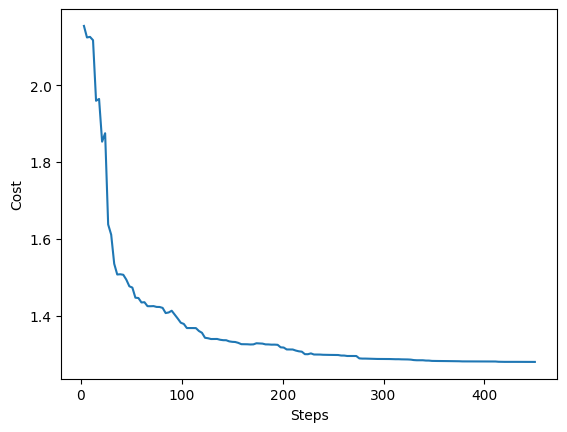

In [277]:

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [278]:
vqc.score(TEST_DATA, test_labels_oh)
print(TEST_DATA)

[[4.6 3.3]
 [6.4 3.3]
 [5.3 2.3]
 [5.8 2.7]
 [6.2 3.3]
 [5.  3.5]
 [5.4 4.1]
 [6.1 3. ]
 [6.  3.3]
 [6.6 3.1]
 [6.7 3.4]
 [6.3 3.2]
 [5.2 2.7]
 [5.8 2.7]
 [7.7 3.1]
 [4.7 3.3]
 [6.  3.1]
 [5.8 3.8]
 [5.1 3.4]
 [7.9 3.3]]


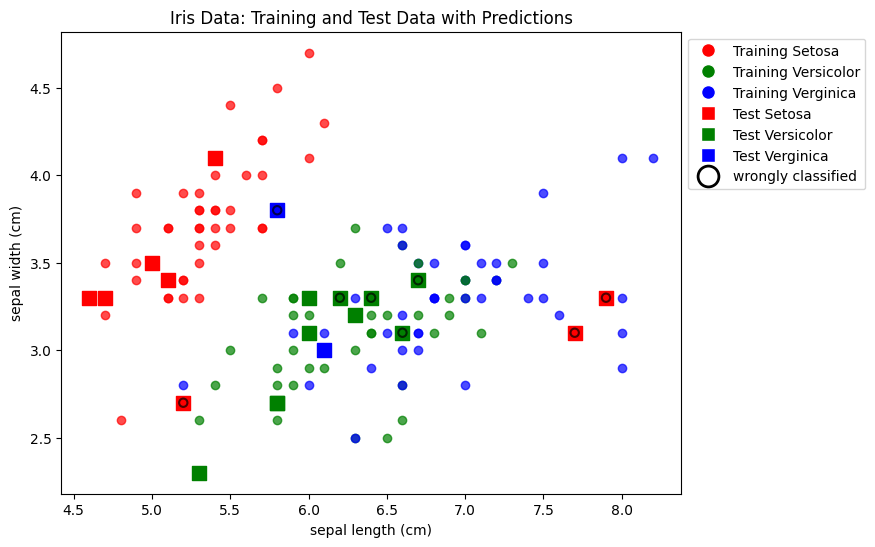

In [279]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np



# Define the colors for the three classes
colors = ['red', 'green', 'blue']
flower_names = iris.target_names
# Create the plot
plt.figure(figsize=(8, 6))

# Plot the training data
for feature, label in zip(TRAIN_DATA, train_labels_oh):
    if label[0] == 0 and label[1] == 0 and label[2] == 1:
        color = 'blue'
    if label[0] == 0 and label[1] == 1 and label[2] == 0:
        color = 'green'
    if label[0] == 1 and label[1] == 0 and label[2] == 0:
        color = 'red'
    plt.scatter(feature[0], feature[1], marker='o',alpha=0.7, color=color)

# Plot the test data with predictions
for feature, label, pred in zip(TEST_DATA, test_labels_oh, vqc.predict(TEST_DATA)):
    if pred[0] == 0 and pred[1] == 0 and pred[2] == 1:
        color = 'blue'
    if pred[0] == 0 and pred[1] == 1 and pred[2] == 0:
        color = 'green'
    if pred[0] == 1 and pred[1] == 0 and pred[2] == 0:
        color = 'red'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=color)
    if not np.array_equal(label, pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', alpha=0.7, linewidths=1.5, facecolor='none', edgecolor='black')


legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='red', label='Training Setosa', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='green', label='Training Versicolor', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='blue', label='Training Verginica', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='red', label='Test Setosa', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='green', label='Test Versicolor', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='blue', label='Test Verginica', ms=10),
           
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='black',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')
# Set labels and title
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Iris Data: Training and Test Data with Predictions")


# Show the plot
plt.show()
